<p align="center">
  <img src="img/image_principal.jpg" width="1000" title="img-principal">
</p>

# 1.0 CONTEXTO DO PROBLEMA

O CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxessem uma previsão das próximas 6 semanas de vendas.

# 2.0 ENTENDIMENTO DO PROBLEMA

**Motivação:**
  - A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas.
   
**Causa do Raiz do Problema:**
   - Dificuldade em determinar o valor do investimento para Reformas de cada Loja.
    
**Quem é o Stakeholder:**
   - Diretor Financeiro (CFO) da Rossmann.
    
**Formato da Solução:**
   - **Granularidade:** Previsão de vendas por Dia da Loja pra os próximos 42 dias, 6 semanas.
   - **Tupo de Problema:** Previsão de Vendas.
   - **Potênciais Métodos:** Séries Temporais, Regressão.
   - **Formato da Entrega:** O valor das Vendas no final de cada 6º semana. E acesso as vendas através do Celular.

# 3.0 COLETA DE DADOS

## 3.1 Importações

In [76]:
import pandas as pd
import inflection
import seaborn as sns
import datetime

import matplotlib.pyplot as plt

## 3.2 Funções Auxiliares

## 3.3 Carregamento de Dados

In [77]:
df_sales = pd.read_csv('data/train.csv', low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)

# merge data
df_raw = pd.merge(df_sales, df_store, how='left', on='Store')

df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 4.0 DESCRIÇÃO DE DADOS

## 4.1 Dimensão de Dados

In [78]:
row = df_raw.shape[0]
col = df_raw.shape[1]

print(f'Número de Linhas: {row}')
print(f'Número de Colunas: {col}')

Número de Linhas: 1017209
Número de Colunas: 18


## 4.2 Tipo de Dados

In [79]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 4.3 Verificação de Dados Faltantes

In [80]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 4.4 Limpeza de Dados

### 4.4.1 Renomeação de Colunas

In [81]:
cols_old = list(df_raw.columns)

snakeCase = lambda x: inflection.underscore(x)
cols_new = list(map(snakeCase, cols_old))

df_raw.columns = cols_new
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 4.4.2 Tratamento de Dados Faltantes

In [82]:
# -- competition_distance
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 200000.0 if pd.isnull(x) else x)


# -- competition_open_since_month
df_raw['competition_open_since_month'] = df_raw[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if pd.isnull(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# -- competition_open_since_year 
df_raw['competition_open_since_year'] = df_raw[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


# -- promo2_since_week
df_raw['promo2_since_week'] = df_raw[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if pd.isnull(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# -- promo2_since_year  
df_raw['promo2_since_year'] = df_raw[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# -- promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

df_raw['is_promo'] = df_raw[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


# Show NaN
df_raw.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 4.4.3 Mudança de Tipo nos Dados

In [83]:
# competition_open_since_month
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype('int64')


# competition_open_since_year
df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype('int64')


#cpromo2_since_week
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype('int64')


# promo2_since_year
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype('int64')

## 4.5 Estatistica Descritiva

### 4.5.1 Atributos Numéricos

In [84]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'])

describe = num_attributes.describe().T

# Add Kutsosis and Skew
describe['skews'] = num_attributes.apply(lambda x: x.skew()) 
describe['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis()) 

describe

,count,mean,std,min,25%,50%,75%,max,skews,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,-7.235657,124.071304


### 4.5.2 Atributos Categóricos

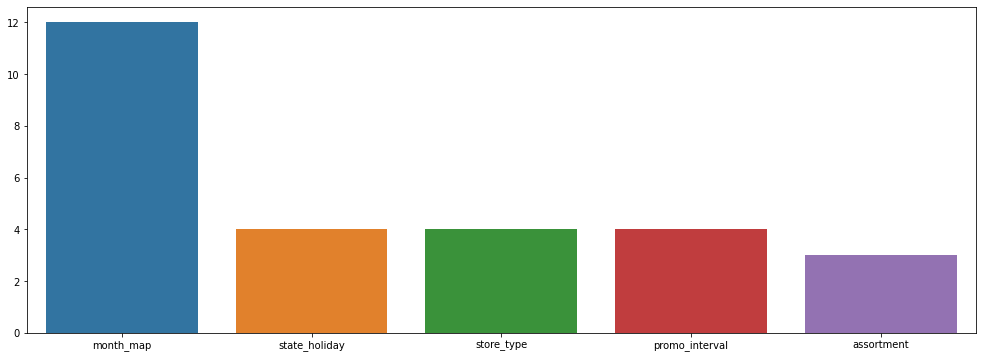

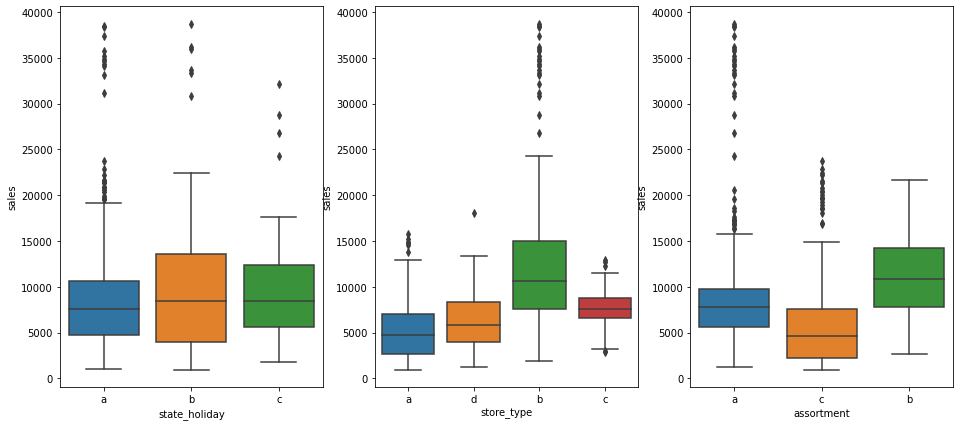

In [85]:
# Filter Categories
cat_attributes = df_raw.select_dtypes(include=['object']) 


# -- Figure 1
unique_values = cat_attributes.apply(lambda x: len(x.unique())).sort_values(ascending=False)
plt.figure(figsize=(17, 6))
sns.barplot(x=unique_values.index, y=unique_values.values)


# -- Figure 2
filter_zero = df_raw[(df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]

plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filter_zero)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filter_zero)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filter_zero);

# 5.0 LVENATAMENTO DE HIPÓTESES

## 5.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="img/mind_map.png" width="1000" title="img-principal">
</p>

## 5.2 Criação de Hipóteses

### 5.2.1  Hipópteses Loja

**1.** Lojas númeuro maior de funcionários vendem mais.

**2.** Lojas com maior capacidade de estoque vendem mais.

**3.** Lojas com maior porte vendem mais.

**4.** Lojas com maior sortimento vendem mais.

**5.** Lojas com competidores mais próximos vendem menos.

**6.** Lojas com competidores à mais tempo vendem mais.

### 5.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing vendem mais.

**2.** Lojas com mais exposição de produtos vendem mais.

**3.** Lojas com menores preços nos produtos vendem mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), vendem mais.

**5.** Lojas com promoções ativas por mais tempo vendem mais.

**6.** Lojas com mais dias de promoção vendem mais.

**7.** Lojas com mais promoções consecutivas vendem mais.

### 5.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal vendem mais.

**2.** Lojas vendem mais ao longo dos anos.

**3.** Lojas vendem mais no segundo semestre do ano.

**4.** Lojas vendem mais depois do dia 10 de cada mês.

**5.** Lojas vendem menos aos finais de semana.

**6.** Lojas vendem menos durante os feriados escolares.

## 5.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento vendem mais.

**2.** Lojas com competidores mais próximos vendem menos.

**3.** Lojas com competidores à mais tempo vendem mais.

**4.** Lojas com promoções ativas por mais tempo vendem mais.

**5.** Lojas com mais dias de promoção vendem mais.

**6.** Lojas com mais promoções consecutivas vendem mais.

**7.** Lojas abertas durante o feriado de Natal vendem mais.

**8.** Lojas vendem mais ao longo dos anos.

**9.** Lojas vendem mais no segundo semestre do ano.

**10.** Lojas vendem mais depois do dia 10 de cada mês.

**11.** Lojas vendem menos aos finais de semana.

**12.** Lojas vendem menos durante os feriados escolares.

# 6.0 FEATURE ENGINEERING

In [90]:
# Year
df_raw['year'] = df_raw['date'].dt.year

# Month
df_raw['month'] = df_raw['date'].dt.month


# Day
df_raw['day'] = df_raw['date'].dt.day


# Week of Year
df_raw['week_of_year'] = df_raw['date'].dt.isocalendar().week


# Year Week
df_raw['year_week'] = df_raw['date'].dt.strftime('%Y-%W')


# Competition since
df_raw['competition_since'] = df_raw.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_raw['competition_time_month'] = ((df_raw['date'] - df_raw['competition_since']) / 30).apply(lambda x: x.days).astype('int')
                                                                                                            
                                                                                                            
# Promo since
df_raw['promo_since'] = df_raw['promo2_since_year'].astype('str') + '-' + df_raw['promo2_since_week'].astype('str')
df_raw['promo_since'] = df_raw['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_raw['promo_time_week'] = ((df_raw['date'] - df_raw['promo_since']) / 7).apply(lambda x: x.days).astype('int')


# Assortment
df_raw['assortment'] = df_raw['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
            
                                                                                                            
# State Holiday
df_raw['state_holiday'] = df_raw['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'  else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')